In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy import interpolate
from scipy.interpolate import interp1d

from astropy.table import Table, Column, vstack, join

In [8]:
from photutils import EllipticalAperture

from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.isophote import build_ellipse_model

### Fake Galaxy

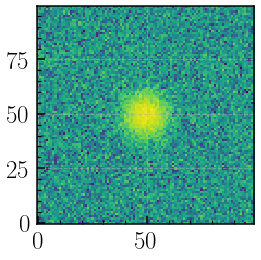

In [2]:
xx, yy = np.meshgrid(
    np.linspace(-8, 8, 100, endpoint=True),
    np.linspace(-8, 8, 100, endpoint=True))

galaxy = 10. * np.exp(-0.5 * (xx ** 2 + yy ** 2))

noise = norm.rvs(1., size=10000).reshape(100, 100)

img = galaxy + noise

extend = [0, img.shape[1], 0, img.shape[0]]

plt.imshow(np.arcsinh(img), origin='lower', interpolation="none")

In [68]:
np.nanmin(img)

-2.9518404595308754

In [76]:
geometry = EllipseGeometry(x0=50, y0=50, sma=4, eps=0.05, pa=20. * np.pi/180., astep=1.0)

img_pos = img

ellipse = Ellipse(img_pos, geometry)

isolist = ellipse.fit_image()

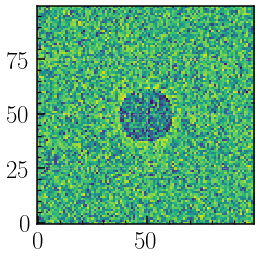

In [77]:
model = build_ellipse_model(img.shape, isolist, high_harmonics=True)

plt.imshow(np.arcsinh(img_pos - model), origin='lower', interpolation='none')

In [23]:
isolist.to_table().colnames

['sma',
 'intens',
 'intens_err',
 'ellipticity',
 'ellipticity_err',
 'pa',
 'pa_err',
 'grad',
 'grad_err',
 'grad_rerr',
 'x0',
 'x0_err',
 'y0',
 'y0_err',
 'ndata',
 'flag',
 'niter',
 'stop_code']

#### Simple benchmark

In [14]:
%timeit isolist = ellipse.fit_image()

2.37 s ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit model = build_ellipse_model(img.shape, isolist)

266 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Sandbox

In [17]:
from scipy.interpolate import LSQUnivariateSpline

### Model building

In [19]:
iso_table = np.asarray(isolist.to_table())

In [21]:
finely_spaced_sma = np.arange(iso_table['sma'][0], iso_table['sma'][-1], 0.1)

In [41]:
import math

In [42]:
def ell_area(sma, eps, phi, r):
    """
    Compute elliptical sector area.
    """

    aux = r * math.cos(phi) / sma
    signal = aux / abs(aux)
    if abs(aux) >= 1.:
        aux = signal
    return abs(sma**2 * (1.-eps) / 2. * math.acos(aux))

### Isophotal fitting - `EllipseGeometry`


#### Initialize the EllipseGeometry object

- Basic geometry: `x0, y0, sma, eps, pa`
    - Here the `sma` should be initial radius: $r_{\rm ini}$
    - **Note**: All the angles are expressed in radian.
- Step size: `astep=0.1, linear_growth=False`
    - Step size: $l$
- Fix parameters: `fix_center=False, fix_pa=False, fix_eps=False`
    - `self.fix = np.array([fix_center, fix_center, fix_pa, fix_eps])`
    - **Note**: should separate `fix_x_center`, `fix_y_center`.
- Sector angular width: `_phi_min = 0.05`; `_phi_max = 0.2`.
    - $\phi_{\rm min} \sim 3$ degree, $\phi_{\rm max} \sim 11$ degree

- The inner radius is either the step size in pixel.
    - The minimum inner radius is 3 pixels
    - For non-linear growth: inner sma is $r_{\rm in} = r_{\rm ini} \times l$

- `self._area_factor` $ = r_{\rm in} \times (r_2 - r_1)$

- When the radius is not zero, define the angular width of the elliptical sector, initial polar angle and polar radius.
    - Initial angular width $\theta$, is $r_{\rm in} / r_{\rm ini}$, but make sure its within [$\phi_{\rm min}, \phi_{\rm max}$]
    - Initial polar angle is the initial angular width divided by 2.0
    - Using the `radius` method to get the initial polar radius

#### `find_center()` function

- Should be replaced with external function, like any object detection algorithm should do better than this.

#### `bounding_ellipses()` method

- For linear growth: $r_1 = r_{\rm ini} - l / 2$; $r_2 = r_{\rm ini} + l / 2$
- For non-linear growth: 
    - $r_1 = r_{\rm ini} \times (1 - l / 2)$
    - $r_2 = r_{\rm ini} \times (1 + l / 2)$

#### `radius()` method

- Calculate the polar radius for a given polar angle
- $r_{\rm polar}= \frac{r_{\rm ini}(1 - e)}{\sqrt{(1-e) \cos{\phi}^2 + \sin{\phi}^2}}$

- See discussion [here](https://math.stackexchange.com/questions/315386/ellipse-in-polar-coordinates)
- In polar coordinate system:
$$
x=r_{\text {polar }} \cos \phi{\text {polar }}, y=r_{\text {polar }} \sin \phi{\text {polar }}
$$

- So the polar radius from the center of the ellipse is 

$$
r_{\text {polar }}=\frac{a b}{\sqrt{\left(b \cos \phi{\text {polar }}\right)^{2}+\left(a \sin \phi{\text {polar }}\right)^{2}}}
$$

#### `_area(sma, eps, phi, r)` function

- Sector area of : $\frac{1}{2} a^2 (1-e) \theta$
- Under the parameterization here:

$$
S_{\rm Sector} = \frac{1}{2} a^2 (1-e) \arccos{(\frac{r}{a} \cos{\phi})}
$$

#### `initialize_sector_geometry(phi)` function

- Initialize geometry attributes associated with an elliptical sector at the given polar angle $\phi$
- This function computes:
    - The four vertices that define the elliptical sector on the
          pixel array.
    - The sector area (saved in the `sector_area` attribute)
    - The sector angular width (saved in `sector_angular_width` attribute)
- The sector centered on $\phi$, with width equals $\theta$
    - So the position angles of the two ends of the sector arre: $\phi_1 = \phi - \theta / 2$, $\phi_2 = \phi + \theta / 2$. This becomes the `._phi1` and `.phi2`.
    - $r_1$ and $r_2$ are the two polar radius at $\phi_1$ for `sma1` and `sma2`
    - $r_3$ and $r_4$ are the two polar radius at $\phi_2$ for `sma1` and `sma2`
    - Calculate the area of the four sectors, the area of the segment used for photometry is: `abs((sa3 - sa2) - (sa4 - sa1))`
    
- 

In [34]:
geometry = EllipseGeometry(x0=50, y0=50, sma=5, eps=0.05, pa=20. * np.pi/180., astep=0.1)

print(geometry._area_factor)
print(geometry.sector_angular_width)
print(geometry.initial_polar_angle)
print(geometry.initial_polar_radius)

0.25
0.1
0.05
4.999325491242547


In [55]:
0.2 * 180.0 / np.pi

11.459155902616464